In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import matplotlib.pyplot as plt
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = True
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 10   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

 --> memory_limit: 4.167 GB


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39497 instead
  warnings.warn(


In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'hbarstreamf' # global heat flux

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'hbarstreamf'
year      = [1979,2019]
# year      = [1958, 1961]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'wbgyr', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 25
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2
which_dpi = 300
do_rescale= False
proj      = 'pc'
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]
do_edgevec_r2g = False

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                          do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
else:
    do_reffig=False  

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto', 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto',
               'edg_n': 'auto'})

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:139: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mesh = pickle.load(fid)


 > comp. e_resol from mean
 > comp n_resol from e_resol
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [5]:
ts = clock.time()
datapath = input_paths[0]
#___________________________________________________________________________
# load information about edges 
fname = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

#___________________________________________________________________________
# set specfic type when loading --> #convert to specific precision
# drop unnecessary variables:  Based on the documentation (but a bit hidden), 
# the "data_vars=" argument only works with Python 3.9.
from functools import partial
var_keep = ['edges', 'edge_tri', 'edge_cross_dxdy']
def _preprocess(x):
    for var in list(x.keys()):
        if var not in var_keep: 
            x = x.drop_vars(var)
            continue
        if x[var].dtype=='float64': x[var] = x[var].astype('float32')
    return x
partial_func = partial(_preprocess)

#___________________________________________________________________________
# load diag file --> apply drop variables by preprocessor function
mdiag = xr.open_mfdataset(os.path.join(dname,fname), parallel=False, 
                             chunks=dict({'edg_n':'auto'}), engine='netcdf4', 
                             preprocess=partial_func)
mdiag = mdiag.drop_vars(list(mdiag.coords)).unify_chunks()

# node indices of edge points [2 x n2ded]--> indices in python start with 0
mdiag['edges']    = mdiag['edges']-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
# --> indices in python start with 0
mdiag['edge_tri'] = mdiag['edge_tri']-1

# Suppress the specific warning about sending large graphs
warnings.filterwarnings("ignore", category=UserWarning, message="Sending large graph of size")

#___________________________________________________________________________
# add edge coordinates and edge mid point coordinates
set_mdiag_chunk = dict({'edg_n': mdiag.chunksizes['edg_n']})
mdiag = mdiag.assign(edge_x = xr.DataArray(mesh.n_x[mdiag.edges], dims=['n2','edg_n']).astype('float32').chunk(set_mdiag_chunk))
mdiag = mdiag.assign(edge_y = xr.DataArray(mesh.n_y[mdiag.edges], dims=['n2','edg_n']).astype('float32').chunk(set_mdiag_chunk))
mdiag = mdiag.drop_vars('edges')

mdiag = mdiag.assign(edge_mx = mdiag.edge_x.sum(dim='n2')/2.0)
mdiag = mdiag.assign(edge_my = mdiag.edge_y.sum(dim='n2')/2.0)

#___________________________________________________________________________
# Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# coordinates (do_edgevec_r2g=True)
if (do_edgevec_r2g):
    mdiag.edge_cross_dxdy[0,:], mdiag.edge_cross_dxdy[1,:] = tpv.vec_r2g(mesh.abg, mdiag.edge_mx, mdiag.edge_my, 
                                                                         mdiag.edge_cross_dxdy[0,:], mdiag.edge_cross_dxdy[1,:], 
                                                                         gridis='geo', do_info=False )
    mdiag.edge_cross_dxdy[2,:], mdiag.edge_cross_dxdy[3,:] = tpv.vec_r2g(mesh.abg, mdiag.edge_mx, mdiag.edge_my, 
                                                                         mdiag.edge_cross_dxdy[2,:], mdiag.edge_cross_dxdy[3,:], 
                                                                         gridis='geo', do_info=False )

#___________________________________________________________________________
set_mdiag_chunk = dict({'edg_n': mdiag.chunksizes['edg_n'], 'n2':mdiag.chunksizes['n2']})
# dx & dy of left triangle --> norm vector 
mdiag = mdiag.assign(edge_dxdy_l=xr.DataArray( np.array([ mdiag.edge_cross_dxdy[1,:], 
                                                         -mdiag.edge_cross_dxdy[0,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))
# dx & dy of right triangle --> norm vector 
mdiag = mdiag.assign(edge_dxdy_r=xr.DataArray( np.array([-mdiag.edge_cross_dxdy[3,:], 
                                                          mdiag.edge_cross_dxdy[2,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))
# if boundarie edge --> right triangle doesnot exist --> therefor dx,dy is zero there
mdiag.edge_dxdy_r[:, mdiag.edge_tri[1,:]<0]=0. 

#___________________________________________________________________________
# restructure edge_dxdy_l & edge_dxdy_r into edge_dx_lr0 & edge_dx_lr1
mdiag = mdiag.assign(edge_dx_lr=xr.DataArray( np.array([ mdiag.edge_dxdy_l[0,:], 
                                                         mdiag.edge_dxdy_r[0,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))
# dx & dy of right triangle --> norm vector 
mdiag = mdiag.assign(edge_dy_lr=xr.DataArray( np.array([ mdiag.edge_dxdy_l[1,:], 
                                                         mdiag.edge_dxdy_r[1,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))

#___________________________________________________________________________
# now drop edge_cross_dxdy variable dont need anymore
mdiag = mdiag.drop_vars(['edge_cross_dxdy', 'edge_dxdy_l', 'edge_dxdy_r'])
mdiag = mdiag.load()

#___________________________________________________________________________
warnings.resetwarnings()
print(mdiag)
print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))
print(' --> mdiag uses {:3.2f} Gb:'.format(mdiag.nbytes/(1024**3)))

<xarray.Dataset>
Dimensions:     (n2: 2, edg_n: 371644)
Dimensions without coordinates: n2, edg_n
Data variables:
    edge_tri    (n2, edg_n) int32 0 3 1 2 6 5 4 7 6 ... -1 -1 -1 -1 -1 -1 -1 -1
    edge_x      (n2, edg_n) float32 -179.7 -179.7 -179.7 ... 175.3 178.5 179.4
    edge_y      (n2, edg_n) float32 -77.94 -77.94 -77.94 ... -77.98 -78.02
    edge_mx     (edg_n) float32 -0.2757 0.1135 -179.4 ... 175.0 178.2 179.0
    edge_my     (edg_n) float32 -77.88 -77.78 -77.84 ... -77.49 -77.9 -78.0
    edge_dx_lr  (n2, edg_n) float32 -2.484e+03 -7.361e+03 -4.272e+03 ... 0.0 0.0
    edge_dy_lr  (n2, edg_n) float32 -5.209e+03 -867.5 8.242e+03 ... 0.0 0.0 0.0
 --> elasped time: 0.055860352516174314 min.
 --> mdiag uses 0.02 Gb:


In [6]:
#______________________________________________________________________________________________________
# create zonal and meridional bins with resolution dlon, dlat
dlon, dlat,  = 1.0, 1.0
lon  = np.arange(-180, 180+dlon, dlon) # --> these are the edges of the bins
lat  = np.arange( -85,  90+dlat, dlat) # --> these are the edges of the bins

#___LOAD FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
hbstreamf_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________________________________
    # load u,v data
    t1 = clock.time()
    data = tpv.load_data_fesom2(mesh, datapath, vname='vec+u+v', year=yeari, descript=descript, do_nan=True, 
                                do_info=True, do_vecrot=False, do_zarithm='None', do_ie2n=False,
                                chunks=chunks, do_compute=False, do_load=True, do_persist=False, )
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________
    # combine edge diagnostic and u,v data on edge_tri indices --> now dataset in context of edge
    # information --> to reindex here towards edges the data need to be unchunked, therefor you putted
    # do_load=True
    data = xr.merge([mdiag, data.u[mdiag.edge_tri,:], data.v[mdiag.edge_tri,:]])
    
    # kick everything out that is not needed anymore, have to kick out lon,lat as well since its here 
    # the lon,lat position of the left and right triangle
    data = data.drop_vars(['edge_tri', 'lon', 'lat', 'elemi', 'elemiz', 'w_A', 'nzi', 'nz1', 'edge_y', 'edge_mx'])

    # add vertical layer thickness as coordinate 
    data = data.assign_coords(dz = xr.DataArray(np.diff(-mesh.zlev).astype('float32'), dims='nz1'))
    data = data.set_coords(['edge_x','edge_my','edge_dx_lr','edge_dy_lr',])

    #__________________________________________________________________________________________________
    print(' --> elasped time to load, prepare u,v data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))

    #__________________________________________________________________________________________________
    # compute  horizontal barotropic streamfunction by binning
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        hbstreamf_ref = tpv.calc_hbarstreamf_fast(mesh, data, lon, lat, do_parallel=do_parallel, n_workers=parallel_nprc_bin)
        if do_reffig: hbstreamf_list.append(hbstreamf_ref) 
        del(data)
        continue
        
    # n_workers ... on how many cpus the binning loop should be parallelized    
    hbstreamf = tpv.calc_hbarstreamf_fast(mesh, data, lon, lat, do_parallel=do_parallel, n_workers=parallel_nprc_bin)

    #_________________________________________________________________________________________________
    # compute anomaly with respect to reference
    if (ref_path != None and ref_path != 'None'): 
        hbstreamf = hbstreamf - hbstreamf_ref
        hbstreamf[list(hbstreamf.keys())[0]].attrs['long_name' ] = '{:s} {:s}'.format('anom.',hbstreamf[list(hbstreamf.keys())[0]].attrs['long_name'])
        hbstreamf[list(hbstreamf.keys())[0]].attrs['short_name'] = '{:s} {:s}'.format('anom.',hbstreamf[list(hbstreamf.keys())[0]].attrs['short_name'])
    
    #_________________________________________________________________________________________________
    hbstreamf_list.append(hbstreamf) 
    
if (ref_path != None and ref_path != 'None'): del(hbstreamf_ref)

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
___FESOM2 DATA INFO________________________
 > Dimensions : Frozen({'elem': 244659, 'nz1': 47})
 > Coordinates:
  * nz1      (nz1) float32 2.5 7.5 15.0 25.0 ... 5.525e+03 5.825e+03 6.125e+03
    nzi      (nz1) uint8 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45 46
    lon      (elem) float32 59.63 -59.63 -179.2 59.8 ... 178.5 178.6 179.0 178.2
    lat      (elem) float32 -77.93 -77.77 -77.9 -77.8 ... -77.75 -77.94 -77.65
    elemi    (elem) int32 0 1 2 3 4 5 ... 244654 244655 244656 244657 244658
    elemiz   (elem) uint8 3 21 20 21 17 20 20 17 13 ... 20 20 21 21 21 3 21 3 21
    w_A      (elem) float32 2.45e+08 3.288e+08 3.101e+08 ... 2.244e+08 3.409e+08
 > Data variables:
    u        (elem, nz1) float32 0.02701 0.0289 0.03048 0.03057 ... nan nan nan
    v        (elem, nz1) float32 0.01148 0.01171 0.01234 0.0134 ... nan nan nan
 ___________________________________________
 --> elasped time to lo

--> histo: cmin, cmax =  -43.104248046875 166.83863830566406
{'cstr': 'blue2red', 'cnum': 25, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -43.1, 'cmax': 166.84, 'cmap': <matplotlib.colors.ListedColormap object at 0x155275319100>, 'clevel': array([-45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,   5.,
        10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
        65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
       120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170.])}


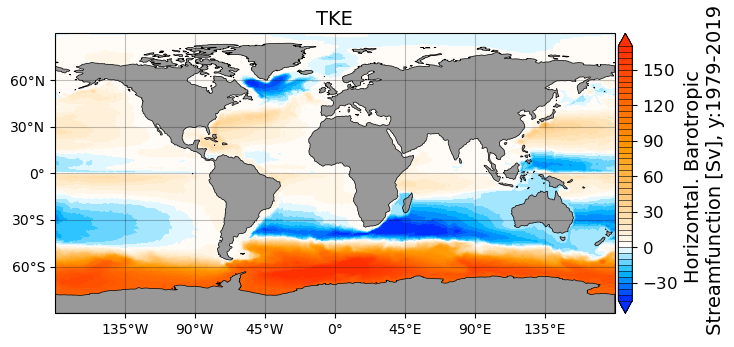

In [8]:
# #___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(hbstreamf_list[0].keys())[0]
slabel = hbstreamf_list[0][sname].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
if save_fname is not None: spath = save_fname
ncolumn= np.min([ncolumn,len(hbstreamf_list)])    
nrow   = np.ceil(len(hbstreamf_list)/ncolumn).astype('int')
pos_gap= [0.005, 0.04]
if proj in ['nps, sps']:pos_gap = [0.005, 0.035]     
cinfo2 = cinfo.copy()    
fig, ax, cbar = tpv.plot_hbstreamf(mesh, hbstreamf_list, input_names, cinfo=cinfo2, box=box, n_rc=[nrow, ncolumn], 
                            figsize=[ncolumn*7, nrow*3.5], proj = proj, 
                            do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale,        
                            do_rescale=do_rescale, title='descript', 
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi)